In [1]:
import gym
import  numpy as np

np.set_printoptions(precision=3)

In [2]:
env = gym.make('FrozenLake-v1', is_slippery=True)

Зима пришла. Вы и ваши друзья бросали фрисби в парке, когда вы сделали дикий бросок, который оставил фрисби посреди озера. Вода в основном замерзла, но есть несколько лунок, где лед растаял. Если вы войдете в одну из этих дыр, вы упадете в ледяную воду. В настоящее время существует нехватка международных фрисби, поэтому абсолютно необходимо, чтобы вы пересекли озеро и забрали диск. Однако лед скользкий, поэтому вы не всегда будете двигаться в том направлении, в котором хотите.

Эпизод заканчивается, когда вы достигаете цели или падаете в яму. Вы получаете вознаграждение в размере 1, если достигаете цели, и ноль в противном случае.

In [3]:
init_state = env.reset()
print(init_state)
env.render()

0

SFFF
FHFH
FFFH
HFFG


Обозначения
<pre class="literal-block">SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
</pre>

Действия:
<pre class="literal-block">
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
</pre>

In [4]:
action_to_symbol = {
    0: '\u2190',
    1: '\u2193',
    2: '\u2192',
    3: '\u2191'
}
for a in action_to_symbol.keys():
    print(a,':', action_to_symbol[a])

0 : ←
1 : ↓
2 : →
3 : ↑


In [5]:
action = env.action_space.sample()
print("action=",action)
next_state, reward, done, info = env.step(action)
print("next_state, reward, done =",next_state, reward, done)

action= 3
next_state, reward, done = 0 0.0 False


In [6]:
init_state = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    next_state, reward, done, info =env.step(action)
    env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG


In [7]:
state = 8
action = 2
print(env.unwrapped.P[state][action])

[(0.3333333333333333, 12, 0.0, True), (0.3333333333333333, 9, 0.0, False), (0.3333333333333333, 4, 0.0, False)]


<pre class="literal-block">
`is_slippery`: True/False. If True will move in intended direction with
probability of 1/3 else will move in either perpendicular direction with
equal probability of 1/3 in both directions.
    For example, if action is left and is_slippery is True, then:
    - P(move left)=1/3
    - P(move up)=1/3
    - P(move down)=1/3
</pre>

In [8]:
class MDP():
    def __init__(self, env):
        self.states = np.arange(env.observation_space.n)
        self.actions = np.arange(env.action_space.n)
        self.P = env.unwrapped.P

In [9]:
mdp = MDP(env)

In [23]:
print(mdp.states)
print(mdp.actions)
state = 8
action = 2
print(mdp.P[state][action])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1 2 3]
[(0.3333333333333333, 12, 0.0, True), (0.3333333333333333, 9, 0.0, False), (0.3333333333333333, 4, 0.0, False)]


In [10]:
probs, next_states, rewards, dones = zip(*mdp.P[state][action])
probs       = np.array(probs, dtype=np.float32)
next_states = np.array(next_states, dtype=np.int32)
rewards     = np.array(rewards, dtype=np.float32)
dones       = np.array(dones, dtype=np.float32)
probs, next_states, rewards, dones

(array([0.333, 0.333, 0.333], dtype=float32),
 array([12,  9,  4], dtype=int32),
 array([0., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32))

In [11]:
V = np.zeros(len(mdp.states), dtype=np.float32)
q_value = np.sum(probs*(rewards + (1-dones)*V[next_states]))
q_value

0.0

In [12]:
def compute_q_value(transitions, V):
    probs, next_states, rewards, dones = zip(*transitions)
    probs       = np.array(probs, dtype=np.float32)
    next_states = np.array(next_states, dtype=np.int32)
    rewards     = np.array(rewards, dtype=np.float32)
    dones       = np.array(dones, dtype=np.float32)
    q_value = np.sum(probs*(rewards + (1-dones)*V[next_states]))
    return q_value

DYNAMIC PROGRAMMING

In [13]:
V = np.zeros(len(mdp.states), dtype=np.float64)
steps_number = 100
for _ in np.arange(steps_number):
    V_next  = np.zeros(len(mdp.states), dtype=np.float64)
    for s in  mdp.states:
        q_values = []
        for a in mdp.actions:
            q_value = compute_q_value(mdp.P[s][a], V)
            q_values.append(q_value)
        V_next[s] = np.max(q_values)
    V = V_next
    print(V.reshape((4,4)))               

[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.333 0.   ]]
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.111 0.   ]
 [0.    0.111 0.444 0.   ]]
[[0.    0.    0.    0.   ]
 [0.    0.    0.037 0.   ]
 [0.    0.074 0.148 0.   ]
 [0.    0.185 0.519 0.   ]]
[[0.    0.    0.012 0.   ]
 [0.    0.    0.049 0.   ]
 [0.025 0.111 0.21  0.   ]
 [0.    0.259 0.568 0.   ]]
[[0.    0.004 0.021 0.004]
 [0.008 0.    0.074 0.   ]
 [0.045 0.165 0.243 0.   ]
 [0.    0.313 0.609 0.   ]]
[[0.004 0.008 0.033 0.01 ]
 [0.018 0.    0.088 0.   ]
 [0.073 0.2   0.283 0.   ]
 [0.    0.362 0.641 0.   ]]
[[0.01  0.015 0.043 0.017]
 [0.032 0.    0.105 0.   ]
 [0.097 0.239 0.31  0.   ]
 [0.    0.401 0.668 0.   ]]
[[0.019 0.023 0.055 0.026]
 [0.046 0.    0.118 0.   ]
 [0.123 0.269 0.337 0.   ]
 [0.    0.436 0.69  0.   ]]
[[0.029 0.032 0.066 0.036]
 [0.063 0.    0.131 0.   ]
 [0.146 0.299 0.359 0.   ]
 [0.    0.465 0.708 0.   ]]
[[0.041 0.043 0.078

VALUE ITERATION

In [14]:
def compute_q_value(transitions, V, gamma):
    probs, next_states, rewards, dones = zip(*transitions)
    probs       = np.array(probs, dtype=np.float32)
    next_states = np.array(next_states, dtype=np.int32)
    rewards     = np.array(rewards, dtype=np.float32)
    dones       = np.array(dones, dtype=np.float32)
    q_value = np.sum(probs*(rewards + gamma*(1-dones)*V[next_states]))
    return q_value

In [15]:
errors = []
V = np.zeros(len(mdp.states), dtype=np.float64)
epsilon = 1e-10
gamma = 0.999
#--------------------------------------------------------------------------
steps_number = 0
while True:
    V_next  = np.zeros(len(mdp.states), dtype=np.float64)
    for s in  mdp.states:
        q_values = []
        for a in mdp.actions:
            q_value = compute_q_value(mdp.P[s][a], V, gamma)
            q_values.append(q_value)
        V_next[s] = np.max(q_values)
    error = np.max(np.abs(V - V_next))
    errors.append(error)
    V = V_next
    steps_number+=1
    if error<=epsilon:
        break
print(steps_number)
print(V.reshape((4,4)))  

774
[[0.786 0.779 0.774 0.772]
 [0.788 0.    0.506 0.   ]
 [0.793 0.8   0.745 0.   ]
 [0.    0.864 0.931 0.   ]]


In [16]:
from matplotlib import pyplot as plt

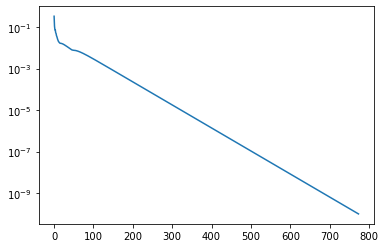

In [18]:
plt.yscale("log") 
plt.plot(errors)

Нахождение оптимальной стратегии

In [19]:
def get_q_fn(mdp, V, gamma):
    """
    return function (state * action-> q_value)
    """
    return lambda state,action: compute_q_value(mdp.P[state][action], V, gamma)

In [20]:
def get_policy(mdp, V, gamma):
    """
    return function (state -> action)
    """
    q_fn  = get_q_fn(mdp, V, gamma)
    return lambda state: np.argmax( [q_fn(state, action) for action in mdp.actions])

policy = get_policy(mdp, V, gamma)

In [21]:
best_actions = np.array([ policy(s) for s in mdp.states  ])
best_actions.reshape( (4,4))

array([[0, 3, 3, 3],
       [0, 0, 0, 0],
       [3, 1, 0, 0],
       [0, 2, 1, 0]])

In [22]:
env.reset()
env.render()
print('Решение:')
print(np.vectorize(action_to_symbol.get)(best_actions.reshape( (4,4))))


SFFF
FHFH
FFFH
HFFG
Решение:
[['←' '↑' '↑' '↑']
 ['←' '←' '←' '←']
 ['↑' '↓' '←' '←']
 ['←' '→' '↓' '←']]


POLICY ITERATION

In [ ]:
init_policy_dict = {s: np.random.choice(mdp.actions) for s in mdp.states} 
init_policy = lambda s: init_policy_dict[s]

In [ ]:
print([init_policy(s) for s in mdp.states])

In [ ]:
def policy_eval(policy, mdp, gamma, epsilon):
    V = np.zeros(len(mdp.states), dtype=np.float64)
    errors = []
    #--------------------------------------------------------------------------
    steps_number = 0
    while True:
        V_next  = np.zeros(len(mdp.states), dtype=np.float64)
        for s in  mdp.states:
            a = policy(s)
            q_value = compute_q_value(mdp.P[s][a], V, gamma)
            V_next[s] = q_value
        error = np.max(np.abs(V - V_next))
        errors.append(error)
        V = V_next
        steps_number+=1
        if error<=epsilon:
            break
    print("Steps=", steps_number)
    return V

In [ ]:
def policy_improvement(V, mdp, policy):
    new_policy = get_policy(mdp, V, gamma)
    return new_policy    

In [ ]:
V = policy_eval(policy, mdp, 0.99, 0.1**10)

In [ ]:
init_policy_dict = {s: np.random.choice(mdp.actions) for s in mdp.states} 
init_policy = lambda s: init_policy_dict[s]
print([init_policy(s) for s in mdp.states])

In [ ]:
policy = init_policy
while True:
    V = policy_eval(policy, mdp, 0.99, 0.1**10)
    new_policy = policy_improvement(V, mdp, policy)
    
    policy_actions= [policy(s) for s in mdp.states]
    new_policy_actions= [new_policy(s) for s in mdp.states]
    policy = new_policy
    if (policy_actions==new_policy_actions):
        break   

In [ ]:
best_actions = np.array([ policy(s) for s in mdp.states  ])
best_actions.reshape( (4,4))

In [ ]:
env.reset()
env.render()
print('Решение:')
print(np.vectorize(action_to_symbol.get)(best_actions.reshape( (4,4))))